In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score

sns.set(rc={'figure.figsize':(20,20)})

current_dir = os.path.abspath('')
parent_dir = os.path.dirname(current_dir)

In [2]:
companies_activity = pd.read_csv(os.path.join(parent_dir, 'datasets', 'company-bankruptcy-prediction', 'data.csv'))
companies_activity.head(5)

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [3]:
cols = companies_activity.columns.to_list()
cols = cols[1:] + cols[:1]
companies_activity = companies_activity[cols]
cols[:-1] = [f'C{i+1}' for i, _ in enumerate(cols[:-1])]
cols[-1] = 'Bankrupt'
companies_activity.columns = cols
companies_activity.head(5)

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,...,C87,C88,C89,C90,C91,C92,C93,C94,C95,Bankrupt
0,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,...,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469,1
1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,...,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794,1
2,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,0.780284,...,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474,1
3,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,0.781241,...,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982,1
4,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,0.781550,...,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490,1


In [4]:
# проверка на NaN-ы
for i in companies_activity.columns:
    if companies_activity[i].isnull().values.any():
        print(i)
        companies_activity[i].fillna(companies_activity[i].mean(), axis=0, inplace=True)

In [5]:
X = companies_activity.drop('Bankrupt', axis=1)
Y = companies_activity['Bankrupt']

In [6]:
right_skew = []
left_skew = []
for i in X.columns:
    if companies_activity[i].skew() < 0:
        left_skew.append(i)
    else:
        right_skew.append(i)

trf_right = FunctionTransformer(func = np.log1p)
trf_left = FunctionTransformer(func = np.square)
trf_right_data = trf_right.fit_transform(companies_activity[right_skew])
trf_left_data = trf_left.fit_transform(companies_activity[left_skew])

data = pd.concat([trf_right_data, trf_left_data, Y], axis=1, join='inner')
data

,C9,C11,C12,C13,C14,C15,C16,C17,C18,C19,...,C75,C77,C80,C82,C86,C88,C89,C90,C93,Bankrupt
0,0.264398,0.000126,0.000000,0.377164,0.000725,0.000000,0.137978,0.137978,0.137978,0.156269,...,0.451003,0.457340,0.406477,0.270797,0.513867,0.387978,0.361746,0.685402,0.318153,1
1,0.265096,0.000290,0.000000,0.379715,0.000647,0.000000,0.167420,0.167420,0.167420,0.189747,...,0.451006,0.095227,0.411009,0.321604,0.632498,0.388941,0.372389,0.705548,0.325099,1
2,0.263929,0.000236,17.054189,0.377423,0.000790,0.000000,0.163742,0.163742,0.177069,0.166006,...,0.451008,0.198941,0.413146,0.289972,0.600113,0.389178,0.361741,0.700191,0.317765,1
3,0.264938,0.000108,0.000000,0.382337,0.000449,0.000000,0.143396,0.143396,0.143396,0.177076,...,0.450938,0.379269,0.335287,0.364943,0.546941,0.388040,0.340516,0.696719,0.318845,1
4,0.265034,22.788862,0.000000,0.380316,0.000686,0.000000,0.154867,0.154867,0.154867,0.192715,...,0.450997,0.950638,0.387349,0.334626,0.632050,0.388778,0.358539,0.705554,0.331335,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6814,0.265061,0.000151,22.227343,0.380991,0.000179,0.107393,0.161307,0.161307,0.161307,0.196062,...,0.451006,0.619193,0.409352,0.344778,0.639883,0.388901,0.365365,0.706203,0.320575,0
6815,0.265068,22.375763,21.087909,0.379790,0.000237,0.315975,0.166636,0.166636,0.166636,0.196139,...,0.451008,0.722327,0.412257,0.324328,0.639598,0.389290,0.357970,0.706114,0.320377,0
6816,0.265062,0.000251,0.000104,0.386750,0.000000,0.399339,0.238640,0.238640,0.238640,0.191388,...,0.450998,0.306876,0.399017,0.347323,0.636450,0.389571,0.372638,0.705832,0.319404,0
6817,0.265052,0.000124,21.643549,0.389419,0.000211,0.166610,0.193420,0.193420,0.193420,0.205652,...,0.451055,0.797879,0.469029,0.460142,0.659032,0.389323,0.369477,0.707422,0.319566,0


<AxesSubplot: >

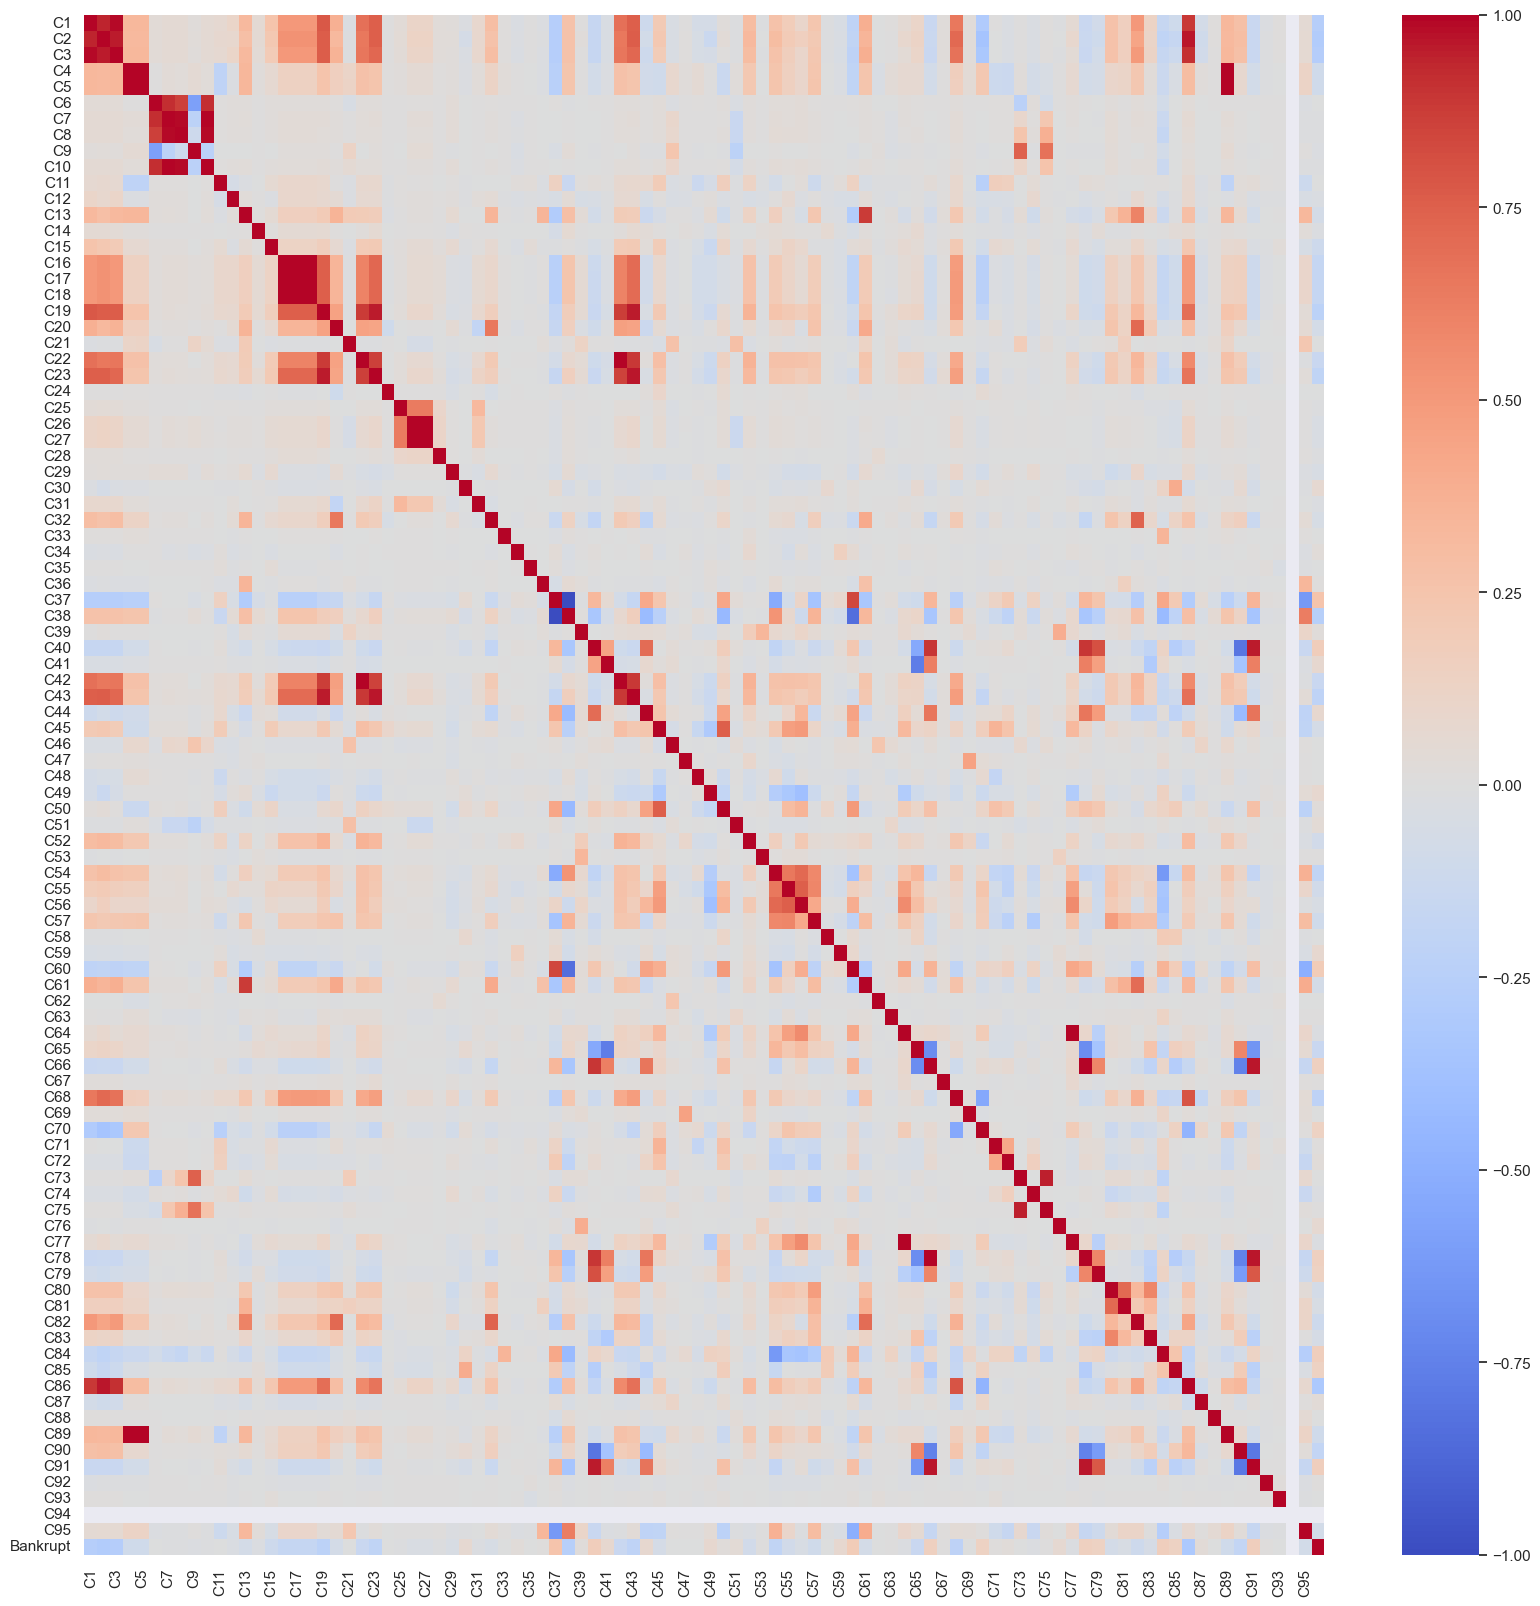

In [7]:
sns.heatmap(companies_activity.corr(), vmin=-1, vmax=1, center=0, cmap='coolwarm')

In [8]:
companies_activity.corrwith(companies_activity['Bankrupt']).abs().sort_values(ascending=False)

Bankrupt    1.000000
C86         0.315457
C2          0.282941
C3          0.273051
C1          0.260807
              ...   
C67         0.000778
C75         0.000479
C24         0.000458
C6          0.000230
C94              NaN
Length: 96, dtype: float64

In [9]:
train_trf, test_trf = np.split(data.sample(frac=1), [int(0.8*len(companies_activity))])
train, test = np.split(companies_activity.sample(frac=1), [int(0.8*len(companies_activity))])

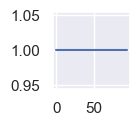

In [10]:
sample = train_trf.drop('Bankrupt', axis=1)
pca_sample = PCA()
sample = pca_sample.fit_transform(sample)
plt.figure(figsize=(1,1))
plt.plot(np.cumsum(pca_sample.explained_variance_ratio_))

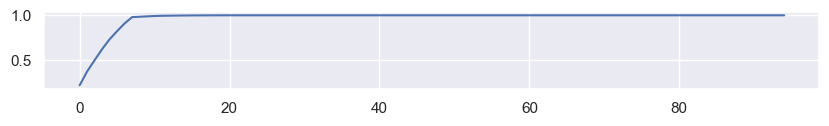

In [11]:
sample = train.drop('Bankrupt', axis=1)
pca_sample = PCA()
sample = pca_sample.fit_transform(sample)
plt.figure(figsize=(10,1))
plt.plot(np.cumsum(pca_sample.explained_variance_ratio_))

In [12]:
companies_activity['Bankrupt'].value_counts()

0    6599
1     220
Name: Bankrupt, dtype: int64

In [13]:
def preprocessing(df, oversampling=True):
    x = df.drop('Bankrupt', axis=1)
    y = df['Bankrupt']
    sc = StandardScaler()
    ros = RandomOverSampler()
    sc.fit_transform(x)
    if oversampling:
        ros.fit_resample(x, y)
    pca = PCA(n_components=10)
    x = pca.fit_transform(x)
    return x, y

In [14]:
X_train, Y_train = preprocessing(train)
X_test, Y_test = preprocessing(test)
X_train_trf, Y_train_trf = preprocessing(train_trf)
X_test_trf, Y_test_trf = preprocessing(test_trf)

In [15]:
model_0 = KNeighborsClassifier()
model_0.fit(X_train, Y_train)

model_1 = LogisticRegression()
model_1.fit(X_train, Y_train)

model_2 = GaussianNB()
model_2.fit(X_train_trf, Y_train_trf)

model_3 = SVC()
model_3.fit(X_train, Y_train)

model_4 = DecisionTreeClassifier()
model_4.fit(X_train, Y_train)

DecisionTreeClassifier()

In [16]:
print(
    f'Точность {model_0} составляет {accuracy_score(Y_test, model_0.predict(X_test))}\n'
    f'Точность {model_1} составляет {accuracy_score(Y_test, model_1.predict(X_test))}\n'
    f'Точность {model_2} составляет {accuracy_score(Y_test_trf, model_2.predict(X_test_trf))}\n'
    f'Точность {model_3} составляет {accuracy_score(Y_test, model_3.predict(X_test))}\n'
    f'Точность {model_4} составляет {accuracy_score(Y_test, model_4.predict(X_test))}'
)

Точность KNeighborsClassifier() составляет 0.9728739002932552
Точность LogisticRegression() составляет 0.5989736070381232
Точность GaussianNB() составляет 0.9699413489736071
Точность SVC() составляет 0.9743401759530792
Точность DecisionTreeClassifier() составляет 0.8966275659824047
